# Ashley Self Project: Wrangling and Analyzing Twitter Data

In [1]:
#Importing all libraries needed
import re
import json
import numpy as np
import pandas as pd
import requests
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 500)
pd.set_option('max_colwidth', 800)

np.random.seed(42)

### Data Gathering

Below are all three pieces of data needed to complete this project

1. Download the WeRateDogs Twitter archived data (twitter-archive-enhanced.csv)

In [2]:
#Importing the twitter archived data provided by Udacity into a DataFrame
df_archive = pd.read_csv('twitter-archive-enhanced.csv')
df_archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,None,None,None,None


In [3]:
#Checking initial shape
df_archive.shape

(2356, 17)

2. Use the requests library to download the tweet image prediction (image_predictions.tsv)

In [4]:
#Downloading the twitter image predictions tsv from Udacity
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)
response.status_code    

200

In [5]:
#Saving the tsv locally
with open('image_predictions.tsv', mode='wb') as file:
    file.write(response.content)

In [6]:
#Importing the tsv into a DataFrame
df_images_predictions = pd.read_csv('image_predictions.tsv', sep='\t')

In [7]:
#Checking first 5 rows for completion of prior code
df_images_predictions.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [8]:
#Checking dataframe shape
df_images_predictions.shape

(2075, 12)

3. Use the Tweepy library to query additional data via the Twitter API (tweet_json.txt)

In [9]:
!pip install -U tweepy==4.0

In [10]:
#Installing new library and fetching tweets from Twitter API
#I did use my API Key and Key Secret when running the code,
#but for security purposes are not displayed here
import tweepy

consumer_key = 'GGrp57kOo0HVOqemy0TZGNGsu' #left blank for security purposes
consumer_secret ='w7tdhqOQomuD9vjCTgqZg9kwgO2iTum829fCqRKQ2iBrITsYH0' #left blank for security purposes
auth = tweepy.AppAuthHandler(consumer_key, consumer_secret)

api = tweepy.API(auth, wait_on_rate_limit=True)

In [11]:
api

In [12]:
#Creating another DataFrame for Tweet IDs
tweet_ids = df_archive.tweet_id.values
len(tweet_ids)

2356

In [13]:
%%time

count = 0
fails_dict = {}

with open('tweet_json.txt', 'w') as outfile:
    for tweet_id in tweet_ids:
        count += 1
        print(str(count) + ": " + str(tweet_id))
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            json.dump(tweet._json, outfile)
            print("Success")
            outfile.write('\n')
        except Exception as e:
            print("Fail")
            fails_dict[tweet_id] = e
        

print(fails_dict)

1: 892420643555336193
Success
2: 892177421306343426
Success
3: 891815181378084864
Success
4: 891689557279858688
Success
5: 891327558926688256
Success
6: 891087950875897856
Success
7: 890971913173991426
Success
8: 890729181411237888
Success
9: 890609185150312448
Success
10: 890240255349198849
Success
11: 890006608113172480
Success
12: 889880896479866881
Success
13: 889665388333682689
Success
14: 889638837579907072
Success
15: 889531135344209921
Success
16: 889278841981685760
Success
17: 888917238123831296
Success
18: 888804989199671297
Success
19: 888554962724278272
Success
20: 888202515573088257
Fail
21: 888078434458587136
Success
22: 887705289381826560
Success
23: 887517139158093824
Success
24: 887473957103951883
Success
25: 887343217045368832
Success
26: 887101392804085760
Success
27: 886983233522544640
Success
28: 886736880519319552
Success
29: 886680336477933568
Success
30: 886366144734445568
Success
31: 886267009285017600
Success
32: 886258384151887873
Success
33: 8860541600590725

Fail
262: 842846295480000512
Success
263: 842765311967449089
Success
264: 842535590457499648
Success
265: 842163532590374912
Success
266: 842115215311396866
Success
267: 841833993020538882
Success
268: 841680585030541313
Success
269: 841439858740625411
Success
270: 841320156043304961
Success
271: 841314665196081154
Success
272: 841077006473256960
Success
273: 840761248237133825
Success
274: 840728873075638272
Success
275: 840698636975636481
Success
276: 840696689258311684
Success
277: 840632337062862849
Success
278: 840370681858686976
Success
279: 840268004936019968
Success
280: 839990271299457024
Success
281: 839549326359670784
Success
282: 839290600511926273
Success
283: 839239871831150596
Success
284: 838952994649550848
Success
285: 838921590096166913
Success
286: 838916489579200512
Success
287: 838831947270979586
Success
288: 838561493054533637
Success
289: 838476387338051585
Success
290: 838201503651401729
Success
291: 838150277551247360
Success
292: 838085839343206401
Success
293

Success
519: 810657578271330305
Success
520: 810284430598270976
Success
521: 810254108431155201
Success
522: 809920764300447744
Success
523: 809808892968534016
Success
524: 809448704142938112
Success
525: 809220051211603969
Success
526: 809084759137812480
Success
527: 808838249661788160
Success
528: 808733504066486276
Success
529: 808501579447930884
Success
530: 808344865868283904
Success
531: 808134635716833280
Success
532: 808106460588765185
Success
533: 808001312164028416
Success
534: 807621403335917568
Success
535: 807106840509214720
Success
536: 807059379405148160
Success
537: 807010152071229440
Success
538: 806629075125202948
Success
539: 806620845233815552
Success
540: 806576416489959424
Success
541: 806542213899489280
Success
542: 806242860592926720
Success
543: 806219024703037440
Success
544: 805958939288408065
Success
545: 805932879469572096
Success
546: 805826884734976000
Success
547: 805823200554876929
Success
548: 805520635690676224
Success
549: 805487436403003392
Success


Success
776: 776201521193218049
Success
777: 776113305656188928
Success
778: 776088319444877312
Success
779: 775898661951791106
Success
780: 775842724423557120
Success
781: 775733305207554048
Success
782: 775729183532220416
Success
783: 775364825476165632
Success
784: 775350846108426240
Success
785: 775096608509886464
Fail
786: 775085132600442880
Success
787: 774757898236878852
Success
788: 774639387460112384
Success
789: 774314403806253056
Success
790: 773985732834758656
Success
791: 773922284943896577
Success
792: 773704687002451968
Success
793: 773670353721753600
Success
794: 773547596996571136
Success
795: 773336787167145985
Success
796: 773308824254029826
Success
797: 773247561583001600
Success
798: 773191612633579521
Success
799: 772877495989305348
Success
800: 772826264096874500
Success
801: 772615324260794368
Success
802: 772581559778025472
Success
803: 772193107915964416
Success
804: 772152991789019136
Success
805: 772117678702071809
Success
806: 772114945936949249
Success
807

Rate limit reached. Sleeping for: 679


Success
902: 758474966123810816
Success
903: 758467244762497024
Success
904: 758405701903519748
Success
905: 758355060040593408
Success
906: 758099635764359168
Success
907: 758041019896193024
Success
908: 757741869644341248
Success
909: 757729163776290825
Success
910: 757725642876129280
Success
911: 757611664640446465
Success
912: 757597904299253760
Success
913: 757596066325864448
Success
914: 757400162377592832
Success
915: 757393109802180609
Success
916: 757354760399941633
Success
917: 756998049151549440
Success
918: 756939218950160384
Success
919: 756651752796094464
Success
920: 756526248105566208
Success
921: 756303284449767430
Success
922: 756288534030475264
Success
923: 756275833623502848
Success
924: 755955933503782912
Success
925: 755206590534418437
Success
926: 755110668769038337
Success
927: 754874841593970688
Success
928: 754856583969079297
Success
929: 754747087846248448
Success
930: 754482103782404096
Success
931: 754449512966619136
Success
932: 754120377874386944
Success


Success
1154: 725729321944506368
Success
1155: 725458796924002305
Success
1156: 724983749226668032
Success
1157: 724771698126512129
Success
1158: 724405726123311104
Success
1159: 724049859469295616
Success
1160: 724046343203856385
Success
1161: 724004602748780546
Success
1162: 723912936180330496
Success
1163: 723688335806480385
Success
1164: 723673163800948736
Success
1165: 723179728551723008
Success
1166: 722974582966214656
Success
1167: 722613351520608256
Success
1168: 721503162398597120
Success
1169: 721001180231503872
Success
1170: 720785406564900865
Success
1171: 720775346191278080
Success
1172: 720415127506415616
Success
1173: 720389942216527872
Success
1174: 720340705894408192
Success
1175: 720059472081784833
Success
1176: 720043174954147842
Success
1177: 719991154352222208
Success
1178: 719704490224398336
Success
1179: 719551379208073216
Success
1180: 719367763014393856
Success
1181: 719339463458033665
Success
1182: 719332531645071360
Success
1183: 718971898235854848
Success
11

Success
1403: 699423671849451520
Success
1404: 699413908797464576
Success
1405: 699370870310113280
Success
1406: 699323444782047232
Success
1407: 699088579889332224
Success
1408: 699079609774645248
Success
1409: 699072405256409088
Success
1410: 699060279947165696
Success
1411: 699036661657767936
Success
1412: 698989035503689728
Success
1413: 698953797952008193
Success
1414: 698907974262222848
Success
1415: 698710712454139905
Success
1416: 698703483621523456
Success
1417: 698635131305795584
Success
1418: 698549713696649216
Success
1419: 698355670425473025
Success
1420: 698342080612007937
Success
1421: 698262614669991936
Success
1422: 698195409219559425
Success
1423: 698178924120031232
Success
1424: 697995514407682048
Success
1425: 697990423684476929
Success
1426: 697943111201378304
Success
1427: 697881462549430272
Success
1428: 697630435728322560
Success
1429: 697616773278015490
Success
1430: 697596423848730625
Success
1431: 697575480820686848
Success
1432: 697516214579523584
Success
14

Success
1652: 683498322573824003
Success
1653: 683481228088049664
Success
1654: 683462770029932544
Success
1655: 683449695444799489
Success
1656: 683391852557561860
Success
1657: 683357973142474752
Success
1658: 683142553609318400
Success
1659: 683111407806746624
Success
1660: 683098815881154561
Success
1661: 683078886620553216
Success
1662: 683030066213818368
Success
1663: 682962037429899265
Success
1664: 682808988178739200
Success
1665: 682788441537560576
Success
1666: 682750546109968385
Success
1667: 682697186228989953
Success
1668: 682662431982772225
Success
1669: 682638830361513985
Success
1670: 682429480204398592
Success
1671: 682406705142087680
Success
1672: 682393905736888321
Success
1673: 682389078323662849
Success
1674: 682303737705140231
Success
1675: 682259524040966145
Success
1676: 682242692827447297
Success
1677: 682088079302213632
Success
1678: 682059653698686977
Success
1679: 682047327939461121
Success
1680: 682032003584274432
Success
1681: 682003177596559360
Success
16

Rate limit reached. Sleeping for: 681


Success
1802: 676957860086095872
Success
1803: 676949632774234114
Success
1804: 676948236477857792
Success
1805: 676946864479084545
Success
1806: 676942428000112642
Success
1807: 676936541936185344
Success
1808: 676916996760600576
Success
1809: 676897532954456065
Success
1810: 676864501615042560
Success
1811: 676821958043033607
Success
1812: 676819651066732545
Success
1813: 676811746707918848
Success
1814: 676776431406465024
Success
1815: 676617503762681856
Success
1816: 676613908052996102
Success
1817: 676606785097199616
Success
1818: 676603393314578432
Success
1819: 676593408224403456
Success
1820: 676590572941893632
Success
1821: 676588346097852417
Success
1822: 676582956622721024
Success
1823: 676575501977128964
Success
1824: 676533798876651520
Success
1825: 676496375194980353
Success
1826: 676470639084101634
Success
1827: 676440007570247681
Success
1828: 676430933382295552
Success
1829: 676263575653122048
Success
1830: 676237365392908289
Success
1831: 676219687039057920
Success
18

Success
2051: 671497587707535361
Success
2052: 671488513339211776
Success
2053: 671486386088865792
Success
2054: 671485057807351808
Success
2055: 671390180817915904
Success
2056: 671362598324076544
Success
2057: 671357843010908160
Success
2058: 671355857343524864
Success
2059: 671347597085433856
Success
2060: 671186162933985280
Success
2061: 671182547775299584
Success
2062: 671166507850801152
Success
2063: 671163268581498880
Success
2064: 671159727754231808
Success
2065: 671154572044468225
Success
2066: 671151324042559489
Success
2067: 671147085991960577
Success
2068: 671141549288370177
Success
2069: 671138694582165504
Success
2070: 671134062904504320
Success
2071: 671122204919246848
Success
2072: 671115716440031232
Success
2073: 671109016219725825
Success
2074: 670995969505435648
Success
2075: 670842764863651840
Success
2076: 670840546554966016
Success
2077: 670838202509447168
Success
2078: 670833812859932673
Success
2079: 670832455012716544
Success
2080: 670826280409919488
Success
20

Success
2300: 667065535570550784
Success
2301: 667062181243039745
Success
2302: 667044094246576128
Success
2303: 667012601033924608
Success
2304: 666996132027977728
Success
2305: 666983947667116034
Success
2306: 666837028449972224
Success
2307: 666835007768551424
Success
2308: 666826780179869698
Success
2309: 666817836334096384
Success
2310: 666804364988780544
Success
2311: 666786068205871104
Success
2312: 666781792255496192
Success
2313: 666776908487630848
Success
2314: 666739327293083650
Success
2315: 666701168228331520
Success
2316: 666691418707132416
Success
2317: 666649482315059201
Success
2318: 666644823164719104
Success
2319: 666454714377183233
Success
2320: 666447344410484738
Success
2321: 666437273139982337
Success
2322: 666435652385423360
Success
2323: 666430724426358785
Success
2324: 666428276349472768
Success
2325: 666421158376562688
Success
2326: 666418789513326592
Success
2327: 666411507551481857
Success
2328: 666407126856765440
Success
2329: 666396247373291520
Success
23

In [14]:
#Checking length of new list
len(fails_dict)

30

In [16]:
#Create new DataFrame from the tweet_json.txt file
json_df = pd.read_json('tweet_json.txt', lines=True, encoding='utf-8')
json_df = json_df.rename(columns={'id': 'tweet_id'})
json_df.head()

,created_at,tweet_id,id_str,full_text,truncated,display_text_range,entities,extended_entities,source,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,in_reply_to_screen_name,user,geo,coordinates,place,contributors,is_quote_status,retweet_count,favorite_count,favorited,retweeted,possibly_sensitive,possibly_sensitive_appealable,lang,retweeted_status,quoted_status_id,quoted_status_id_str,quoted_status_permalink,quoted_status
0,2017-08-01 16:23:56+00:00,892420643555336193,892420643555336192,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,False,"[0, 85]","{'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [], 'media': [{'id': 892420639486877696, 'id_str': '892420639486877696', 'indices': [86, 109], 'media_url': 'http://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg', 'media_url_https': 'https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg', 'url': 'https://t.co/MgUWQ76dJU', 'display_url': 'pic.twitter.com/MgUWQ76dJU', 'expanded_url': 'https://twitter.com/dog_rates/status/892420643555336193/photo/1', 'type': 'photo', 'sizes': {'thumb': {'w': 150, 'h': 150, 'resize': 'crop'}, 'medium': {'w': 540, 'h': 528, 'resize': 'fit'}, 'small': {'w': 540, 'h': 528, 'resize': 'fit'}, 'large': {'w': 540, 'h': 528, 'resize': 'fit'}}}]}","{'media': [{'id': 892420639486877696, 'id_str': '892420639486877696', 'indices': [86, 109], 'media_url': 'http://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg', 'media_url_https': 'https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg', 'url': 'https://t.co/MgUWQ76dJU', 'display_url': 'pic.twitter.com/MgUWQ76dJU', 'expanded_url': 'https://twitter.com/dog_rates/status/892420643555336193/photo/1', 'type': 'photo', 'sizes': {'thumb': {'w': 150, 'h': 150, 'resize': 'crop'}, 'medium': {'w': 540, 'h': 528, 'resize': 'fit'}, 'small': {'w': 540, 'h': 528, 'resize': 'fit'}, 'large': {'w': 540, 'h': 528, 'resize': 'fit'}}}]}","<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",NaN,NaN,NaN,NaN,None,"{'id': 4196983835, 'id_str': '4196983835', 'name': 'WeRateDogs®', 'screen_name': 'dog_rates', 'location': 'all our links ➜', 'description': 'Your Only Source For Professional Dog Ratings Instagram and Facebook ➜ WeRateDogs partnerships@weratedogs.com | nonprofit: @15outof10 ⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀', 'url': 'https://t.co/YPc2Xq4Va2', 'entities': {'url': {'urls': [{'url': 'https://t.co/YPc2Xq4Va2', 'expanded_url': 'http://links.weratedogs.com', 'display_url': 'links.weratedogs.com', 'indices': [0, 23]}]}, 'description': {'urls': []}}, 'protected': False, 'followers_count': 9377777, 'friends_count': 20, 'listed_count': 7852, 'created_at': 'Sun Nov 15 21:41:29 +0000 2015', 'favourites_count': 147765, 'utc_offset': None, 'time_zone': None, 'geo_enabled': True, 'verified': True, 'statuses_count': 17393...",NaN,NaN,None,NaN,False,6902,32981,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN
1,2017-08-01 00:17:27+00:00,892177421306343426,892177421306343424,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",False,"[0, 138]","{'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [], 'media': [{'id': 892177413194625024, 'id_str': '892177413194625024', 'indices': [139, 162], 'media_url': 'http://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg', 'media_url_https': 'https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg', 'url': 'https://t.co/0Xxu71qeIV', 'display_url': 'pic.twitter.com/0Xxu71qeIV', 'expanded_url': 'https://twitter.com/dog_rates/status/892177421306343426/photo/1', 'type': 'photo', 'sizes': {'thumb': {'w': 150, 'h': 150, 'resize': 'crop'}, 'medium': {'w': 1055, 'h': 1200, 'resize': 'fit'}, 'small': {'w': 598, 'h': 680, 'resize': 'fit'}, 'large': {'w': 1407, 'h': 1600, 'resize': 'fit'}}}]}","{'media': [{'id': 892177413194625024, 'id_str': '892177413194625024', 'indices': [139, 162], 'media_url': 'http://pbs.twimg.com/m

In [17]:
#Pulling in just these four columns
json_df = json_df[['tweet_id', 'favorite_count', 'retweet_count']]

In [18]:
json_df.head()

,tweet_id,favorite_count,retweet_count
0,892420643555336193,32981,6902
1,892177421306343426,28518,5201
2,891815181378084864,21438,3433
3,891689557279858688,35948,7109
4,891327558926688256,34376,7637


### Assessing the Data

1. Assess the Twitter Archive file

In [19]:
#First, assess the twitter archive file visually,
#looking for quality and tidiness
#A summary of findings will be included later
pd.options.display.max_colwidth = 10000
df_archive

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have a 1949 1st generation vulpix. Enjoys sweat tea and Fox News. Cannot be phased. 5/10 https://t.co/4B7cOc1EDq,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248165822465/photo/1,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is a purebred Piers Morgan. Loves to Netflix and chill. Always looks like he forgot to unplug the iron. 6/10 https://t.co/DWnyCjf2mx,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226329800704/photo/1,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here is a very happy pup. Big fan of well-maintained decks. Just look at that tongue. 9/10 would cuddle af https://t.co/y671yMhoiR,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412701032449/photo/1,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is a western brown Mitsubishi terrier. Upset about leaf. Actually 2 dogs here. 7/10 would walk the shit out of https://t.co/r7mOb2m0UI,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285002620928/photo/1,7,10,a,None,None,None,None


In [20]:
df_archive['time_stamp'] = pd.to_datetime(df_archive['timestamp'])

In [21]:
#Assess the data programmatically
df_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    2356 non-null   int64              
 1   in_reply_to_status_id       78 non-null     float64            
 2   in_reply_to_user_id         78 non-null     float64            
 3   timestamp                   2356 non-null   object             
 4   source                      2356 non-null   object             
 5   text                        2356 non-null   object             
 6   retweeted_status_id         181 non-null    float64            
 7   retweeted_status_user_id    181 non-null    float64            
 8   retweeted_status_timestamp  181 non-null    object             
 9   expanded_urls               2297 non-null   object             
 10  rating_numerator            2356 non-null   int64           

We know that most of the columns with NaN are common, as most tweets in this dataset are not replies and/or retweets, however, we should still work to drop all retweets to clean up the data.

In [22]:
#Look at expanded_urls to see if NaN values are retweets or original tweets
df_archive[df_archive['expanded_urls'].isnull()].loc[:, ['expanded_urls',
                                                         'in_reply_to_status_id',
                                                         'in_reply_to_user_id',
                                                         'retweeted_status_id']]

,expanded_urls,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id
30,NaN,8.862664e+17,2.281182e+09,NaN
55,NaN,8.816070e+17,4.738443e+07,NaN
64,NaN,8.795538e+17,3.105441e+09,NaN
113,NaN,8.707262e+17,1.648776e+07,NaN
148,NaN,8.634256e+17,7.759620e+07,NaN
179,NaN,8.571567e+17,1.806710e+08,NaN
185,NaN,NaN,NaN,8.563302e+17
186,NaN,8.562860e+17,2.792810e+08,NaN
188,NaN,8.558616e+17,1.943518e+08,NaN
189,NaN,8.558585e+17,1.361572e+07,NaN


We can see in the code above that only four expanded_urls with NaN are original tweets, and not replies/retweets (185, 375, 707, 1445).

In [23]:
#By expanding these four tweets, we see that the first one (185) is a retweet by the RT@ in the text column - issue found!
url_nan_original_tweets = df_archive.iloc[[185, 375, 707, 1445], :].tweet_id
df_archive.iloc[[185, 375, 707, 1445], :]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,time_stamp
185,856330835276025856,NaN,NaN,2017-04-24 02:15:55 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @Jenna_Marbles: @dog_rates Thanks for rating my cermets 14/10 wow I'm so proud I watered them so much,8.563302e+17,66699013.0,2017-04-24 02:13:14 +0000,NaN,14,10,None,None,None,None,None,2017-04-24 02:15:55+00:00
375,828361771580813312,NaN,NaN,2017-02-05 21:56:51 +0000,"<a href=""http://twitter.com"" rel=""nofollow"">Twitter Web Client</a>",Beebop and Doobert should start a band 12/10 would listen,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None,2017-02-05 21:56:51+00:00
707,785515384317313025,NaN,NaN,2016-10-10 16:20:36 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","Today, 10/10, should be National Dog Rates Day",NaN,NaN,NaN,NaN,10,10,None,None,None,None,None,2016-10-10 16:20:36+00:00
1445,696518437233913856,NaN,NaN,2016-02-08 02:18:30 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Oh my god 10/10 for every little hot dog pupper,NaN,NaN,NaN,NaN,10,10,None,None,None,pupper,None,2016-02-08 02:18:30+00:00


#### Quality and Tidiness Issues - df_archive

##### Quality
1. Too many retweets present in the dataframe, we want original tweets only
2. The text column also contains text followed by a url, this should be cleaned up and either separated, or condensed to just text
3. Need to change data type from int to string for tweet_id column

##### Tidiness
1. The last four columns: doggo, floofer, pupper, puppo can be combined into one column with a filter to condense and clean up the data
2. Spitting the timestamp column would be helpful - separate them into two columns: date and time

2. Assess the Image Predictions file

In [24]:
#First, assess the image predictions file visually,
#looking for quality and tidiness
#A summary of findings will be included later
df_images_predictions

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True


In [25]:
#Assess the data programmatically
df_images_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


Through programmatic assessing in the code above, we see that no columns have NaN values!

In [26]:
df_images_predictions.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [27]:
df_images_predictions.sample(10)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
881,698703483621523456,https://pbs.twimg.com/media/CbJLG0HWwAAV-ug.jpg,1,Brittany_spaniel,0.931963,True,Welsh_springer_spaniel,0.030695,True,beagle,0.012896,True
453,674754018082705410,https://pbs.twimg.com/media/CV01M3ZWIAAV7rv.jpg,1,seashore,0.352321,False,promontory,0.131753,False,wreck,0.095597,False
2004,877316821321428993,https://pbs.twimg.com/media/DCza_vtXkAQXGpC.jpg,1,Saluki,0.509967,True,Italian_greyhound,0.090497,True,golden_retriever,0.079406,True
1353,760190180481531904,https://pbs.twimg.com/media/Coy87yiWYAACtPf.jpg,1,balloon,0.917525,False,confectionery,0.049329,False,maraca,0.017648,False
281,671122204919246848,https://pbs.twimg.com/media/CVBOFTLWwAAzlNi.jpg,1,goose,0.351957,False,Chihuahua,0.101228,True,hen,0.065818,False
941,704054845121142784,https://pbs.twimg.com/media/CcVOJEcXEAM0FHL.jpg,1,Great_Pyrenees,0.667939,True,kuvasz,0.228764,True,golden_retriever,0.043885,True
1185,738885046782832640,https://pbs.twimg.com/media/CkEMBz9WYAAGLaa.jpg,1,bath_towel,0.878320,False,swab,0.020633,False,American_Staffordshire_terrier,0.015535,True
1159,733828123016450049,https://pbs.twimg.com/media/Ci8UxxcW0AYgHDh.jpg,2,beagle,0.472324,True,Walker_hound,0.121779,True,Saint_Bernard,0.114640,True
1138,729113531270991872,https://pbs.twimg.com/media/Ch5U4FzXEAAShhF.jpg,2,stone_wall,0.606188,False,prison,0.064831,False,bannister,0.048048,False
599,679729593985699840,https://pbs.twimg.com/media/CW7iddWUsAElUC0.jpg,1,wallaby,0.164215,False,West_Highland_white_terrier,0.093515,True,ashcan,0.067278,False


There is no data that seems out of place with the descriptive statistics of this df or the sample above.

In [28]:
sum(df_images_predictions.duplicated(subset=['jpg_url']))

66

#### Quality and Tidiness Issues - df_images_predictions

##### Quality

1. There is a mix of capitalized and non-capitalized dog breeds in multiple columns (needs consistency)
2. Multiple columns have non-descriptive names (ie: p1, p1_conf, p1_dog, p2, p2_conf, p2_dog, p3, p3_conf, p3_dog)
3. Need to drop the 66 duplicates in the jpg_url column

3. Assess the Tweet json file

In [29]:
#First, assess the image predictions file visually,
#looking for quality and tidiness
#A summary of findings will be included later
json_df

,tweet_id,favorite_count,retweet_count
0,892420643555336193,32981,6902
1,892177421306343426,28518,5201
2,891815181378084864,21438,3433
3,891689557279858688,35948,7109
4,891327558926688256,34376,7637
...,...,...,...
2321,666049248165822465,87,36
2322,666044226329800704,243,113
2323,666033412701032449,98,35
2324,666029285002620928,111,39


In [30]:
#Assess the data programmatically
json_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2326 entries, 0 to 2325
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   tweet_id        2326 non-null   int64
 1   favorite_count  2326 non-null   int64
 2   retweet_count   2326 non-null   int64
dtypes: int64(3)
memory usage: 54.6 KB


Through programmatic assessing in the code above, we see that no columns have NaN values, too!

#### Quality and Tidiness Issues - json_df

##### Quality

1. Too many retweets present in the dataframe, we want original tweets only

### Cleaning the Data

In [31]:
#Make a copy of all three datasets
df_archive_clean = df_archive.copy()
df_images_predictions_clean = df_images_predictions.copy()
json_df_clean = json_df.copy()

###### Address Quality Issue:
1. & 2. Too many retweets present in the dataframe, we want original tweets only (with images) - addresses two quality issues
            Cleans both NaN values and deletes unecessary columns with retweeted info and replies

In [32]:
df_archive_clean = df_archive_clean[pd.isnull(df_archive_clean['retweeted_status_id'])]

In [33]:
#Testing code to make sure it worked
print(sum(df_archive_clean.retweeted_status_id.value_counts()))

0


In [34]:
df_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    2175 non-null   int64              
 1   in_reply_to_status_id       78 non-null     float64            
 2   in_reply_to_user_id         78 non-null     float64            
 3   timestamp                   2175 non-null   object             
 4   source                      2175 non-null   object             
 5   text                        2175 non-null   object             
 6   retweeted_status_id         0 non-null      float64            
 7   retweeted_status_user_id    0 non-null      float64            
 8   retweeted_status_timestamp  0 non-null      object             
 9   expanded_urls               2117 non-null   object             
 10  rating_numerator            2175 non-null   int64           

Filtered/deleted all retweeted information through above code - works by showing retweeted columns as 0 counted.

In [35]:
#Get rid of columns related to retweets and replies
df_archive_clean = df_archive_clean.drop(['retweeted_status_id',
                                          'retweeted_status_user_id',
                                          'retweeted_status_timestamp',
                                          'in_reply_to_status_id',
                                          'in_reply_to_user_id'],
                                         axis=1)

In [36]:
#Make sure it worked
df_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2175 non-null   int64              
 1   timestamp           2175 non-null   object             
 2   source              2175 non-null   object             
 3   text                2175 non-null   object             
 4   expanded_urls       2117 non-null   object             
 5   rating_numerator    2175 non-null   int64              
 6   rating_denominator  2175 non-null   int64              
 7   name                2175 non-null   object             
 8   doggo               2175 non-null   object             
 9   floofer             2175 non-null   object             
 10  pupper              2175 non-null   object             
 11  puppo               2175 non-null   object             
 12  time_stamp          2175 non-null 

Works - issues resolved!

###### Address Quality Issue:

3. The text column also contains text followed by a url, this should be cleaned up and either separated, or condensed to just text

In [37]:
#Cleaned output will be stored in a list
def new_list(dataframe, column, word):
    text_list = []
    for text in dataframe[column]:
        text_list.append(text)
    clean_text_list = []
    for text_2 in text_list:
        clean_text = text_2[:text_2.find(word)-1]
        clean_text_list.append(clean_text)
    return(clean_text_list)

In [38]:
#Create a new column with the clean text list to make sure the code works
df_archive_clean['new_text'] = new_list(df_archive_clean, 'text', 'https')

In [39]:
#View old and new column to make sure all code works
df_archive_clean.loc[:, ['text', 'new_text']]

,text,new_text
0,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10
1,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10"
2,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10
3,This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us
4,"This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek"
...,...,...
2351,Here we have a 1949 1st generation vulpix. Enjoys sweat tea and Fox News. Cannot be phased. 5/10 https://t.co/4B7cOc1EDq,Here we have a 1949 1st generation vulpix. Enjoys sweat tea and Fox News. Cannot be phased. 5/10
2352,This is a purebred Piers Morgan. Loves to Netflix and chill. Always looks like he forgot to unplug the iron. 6/10 https://t.co/DWnyCjf2mx,This is a purebred Piers Morgan. Loves to Netflix and chill. Always looks like he forgot to unplug the iron. 6/10
2353,Here is a very happy pup. Big fan of well-maintained decks. Just look at that tongue. 9/10 would cuddle af https://t.co/y671yMhoiR,Here is a very happy pup. Big fan of well-maintained decks. Just look at that tongue. 9/10 would cuddle af
2354,This is a western brown Mitsubishi terrier. Upset about leaf. Actually 2 dogs here. 7/10 would walk the shit out of https://t.co/r7mOb2m0UI,This is a western brown Mitsubishi terrier. Upset about leaf. Actually 2 dogs here. 7/10 would walk the shit out of


It worked! Now lets input the new column into the old column, overriding the original data

In [40]:
df_archive_clean['text'] = new_list(df_archive_clean, 'text', 'https')
df_archive_clean = df_archive_clean.drop(['new_text'], axis=1)

In [41]:
#Check to make sure code works
df_archive_clean.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,time_stamp
0,892420643555336193,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None,2017-08-01 16:23:56+00:00
1,892177421306343426,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10",https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,None,None,None,None,2017-08-01 00:17:27+00:00
2,891815181378084864,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,None,None,None,None,2017-07-31 00:18:03+00:00
3,891689557279858688,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,None,None,None,None,2017-07-30 15:58:51+00:00
4,891327558926688256,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek","https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,None,None,None,None,2017-07-29 16:00:24+00:00


Viola - it worked! Issue resolved.

###### Address Quality Issue:

4. Need to change data type from int to string for tweet_id column in all files

In [42]:
df_archive_clean['tweet_id'] = df_archive_clean['tweet_id'].astype('str')
df_images_predictions_clean['tweet_id'] = df_images_predictions_clean['tweet_id'].astype('str')
json_df_clean['tweet_id'] = json_df_clean['tweet_id'].astype('str')

In [43]:
#Check to make sure code works
df_archive_clean.info()
df_images_predictions_clean.info()
json_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2175 non-null   object             
 1   timestamp           2175 non-null   object             
 2   source              2175 non-null   object             
 3   text                2175 non-null   object             
 4   expanded_urls       2117 non-null   object             
 5   rating_numerator    2175 non-null   int64              
 6   rating_denominator  2175 non-null   int64              
 7   name                2175 non-null   object             
 8   doggo               2175 non-null   object             
 9   floofer             2175 non-null   object             
 10  pupper              2175 non-null   object             
 11  puppo               2175 non-null   object             
 12  time_stamp          2175 non-null 

Works - issue resolved!

###### Address Quality Issue:

5. After looking at the data programmatically, we find that some of the urls in expanded_urls are missing
            *We can look at tweet_id to possibly get the missing urls

In [44]:
def add_urls(row):
    if pd.notnull(row['expanded_urls']):
        return row
    else:
        tweet_id = row['tweet_id']
        row['expanded_urls'] = 'https://twitter.com/dog_rates/status/{}'.format(tweet_id)
        return row

df_archive_clean = df_archive_clean.apply(add_urls, axis=1)

In [46]:
#Check to make sure code works
df_archive_clean[df_archive_clean['expanded_urls'].isnull()]
df_archive_clean.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,time_stamp
0,892420643555336193,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None,2017-08-01 16:23:56+00:00
1,892177421306343426,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10",https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,None,None,None,None,2017-08-01 00:17:27+00:00
2,891815181378084864,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,None,None,None,None,2017-07-31 00:18:03+00:00
3,891689557279858688,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,None,None,None,None,2017-07-30 15:58:51+00:00
4,891327558926688256,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek","https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,None,None,None,None,2017-07-29 16:00:24+00:00


###### Address Quality Issue:

6. There is a mix of capitalized and non-capitalized dog breeds in multiple columns (needs consistency)

In [47]:
df_images_predictions_clean['p1'] = df_images_predictions_clean['p1'].str.title()
df_images_predictions_clean['p2'] = df_images_predictions_clean['p2'].str.title()
df_images_predictions_clean['p3'] = df_images_predictions_clean['p3'].str.title()

In [49]:
#Check to make sure code works
df_images_predictions_clean.loc[:,['p1', 'p2', 'p3']].head()

,p1,p2,p3
0,Welsh_Springer_Spaniel,Collie,Shetland_Sheepdog
1,Redbone,Miniature_Pinscher,Rhodesian_Ridgeback
2,German_Shepherd,Malinois,Bloodhound
3,Rhodesian_Ridgeback,Redbone,Miniature_Pinscher
4,Miniature_Pinscher,Rottweiler,Doberman


Works - issue resolved!

###### Address Quality Issue:

7. Multiple columns have non-descriptive names (ie: p1, p1_conf, p1_dog, p2, p2_conf, p2_dog, p3, p3_conf, p3_dog)

In [50]:
df_images_predictions_clean = df_images_predictions_clean.rename(columns={'jpg_url': 'image_url',
                                                                  'img_num': 'image_number',
                                                                 'p1': 'top_prediction',
                                                                  'p1_conf': 'top_prediction_confidence',
                                                                  'p2': 'second_prediction',
                                                                  'p2_conf': 'second_prediction_confidence',
                                                                  'p3': 'third_prediction',
                                                                  'p3_conf': 'third_prediction_confidence',
                                                                  'p1_dog': 'top_dog_prediction',
                                                                  'p2_dog': 'second_dog_prediction',
                                                                  'p3_dog': 'third_dog_prediction',
                                                                 })

In [51]:
#Check to make sure code works
df_images_predictions_clean.head()

,tweet_id,image_url,image_number,top_prediction,top_prediction_confidence,top_dog_prediction,second_prediction,second_prediction_confidence,second_dog_prediction,third_prediction,third_prediction_confidence,third_dog_prediction
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_Springer_Spaniel,0.465074,True,Collie,0.156665,True,Shetland_Sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,Redbone,0.506826,True,Miniature_Pinscher,0.074192,True,Rhodesian_Ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_Shepherd,0.596461,True,Malinois,0.138584,True,Bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_Ridgeback,0.408143,True,Redbone,0.360687,True,Miniature_Pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,Miniature_Pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


Works - issue resolved!

###### Address Quality Issue:

8. Need to drop the 66 duplicates in the jpg_url column

In [52]:
df_images_predictions_clean = df_images_predictions_clean.drop_duplicates(subset = ['image_url'], keep='last')

In [53]:
#Check to make sure code works
sum(df_images_predictions_clean['image_url'].duplicated())

0

Works - issue resolved!

###### Address Tidiness Issue:

1. The last four columns: doggo, floofer, pupper, puppo can be combined into one column with a filter to condense and clean up the data

In [68]:
df_archive_clean['doggo'].replace('None', '', inplace=True)
df_archive_clean['floofer'].replace('None', '', inplace=True)
df_archive_clean['pupper'].replace('None', '', inplace=True)
df_archive_clean['puppo'].replace('None', '', inplace=True)

KeyError: 'doggo'

In [69]:
df_archive_clean['level_of_dog'] = (df_archive_clean['doggo'] +
                                    df_archive_clean['floofer'] +
                                    df_archive_clean['pupper'] +
                                    df_archive_clean['puppo'])

KeyError: 'doggo'

In [70]:
df_archive_clean = df_archive_clean.drop(['doggo', 'floofer', 'pupper', 'puppo'], axis=1)

KeyError: "['doggo', 'floofer', 'pupper', 'puppo'] not found in axis"

In [71]:
df_archive_clean['level_of_dog'].replace('', 'NaN', inplace=True)

In [72]:
#Check to make sure code works
df_archive_clean['level_of_dog'].value_counts()

NaN             1831
pupper           224
doggo             75
puppo             24
doggopupper       10
floofer            9
doggopuppo         1
doggofloofer       1
Name: level_of_dog, dtype: int64

In [73]:
df_archive_clean.loc[df_archive_clean.level_of_dog == 'doggopupper'] = 'doggo, pupper'
df_archive_clean.loc[df_archive_clean.level_of_dog == 'doggopuppo'] = 'doggo, puppo'
df_archive_clean.loc[df_archive_clean.level_of_dog == 'doggofloofer'] = 'doggo, floofer'

In [74]:
df_archive_clean['level_of_dog'].value_counts()

NaN               1831
pupper             224
doggo               75
puppo               24
doggo, pupper       10
floofer              9
doggo, puppo         1
doggo, floofer       1
Name: level_of_dog, dtype: int64

Works - fixed Udacity Reviewers required change for level of dog.

In [75]:
df_archive_clean.info()
df_archive_clean.tail()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_id            2175 non-null   object
 1   timestamp           2175 non-null   object
 2   source              2175 non-null   object
 3   text                2175 non-null   object
 4   expanded_urls       2175 non-null   object
 5   rating_numerator    2175 non-null   object
 6   rating_denominator  2175 non-null   object
 7   name                2175 non-null   object
 8   time_stamp          2175 non-null   object
 9   level_of_dog        2175 non-null   object
dtypes: object(10)
memory usage: 186.9+ KB


,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,time_stamp,level_of_dog
2351,666049248165822465,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have a 1949 1st generation vulpix. Enjoys sweat tea and Fox News. Cannot be phased. 5/10,https://twitter.com/dog_rates/status/666049248165822465/photo/1,5,10,None,2015-11-16 00:24:50+00:00,NaN
2352,666044226329800704,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is a purebred Piers Morgan. Loves to Netflix and chill. Always looks like he forgot to unplug the iron. 6/10,https://twitter.com/dog_rates/status/666044226329800704/photo/1,6,10,a,2015-11-16 00:04:52+00:00,NaN
2353,666033412701032449,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here is a very happy pup. Big fan of well-maintained decks. Just look at that tongue. 9/10 would cuddle af,https://twitter.com/dog_rates/status/666033412701032449/photo/1,9,10,a,2015-11-15 23:21:54+00:00,NaN
2354,666029285002620928,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is a western brown Mitsubishi terrier. Upset about leaf. Actually 2 dogs here. 7/10 would walk the shit out of,https://twitter.com/dog_rates/status/666029285002620928/photo/1,7,10,a,2015-11-15 23:05:30+00:00,NaN
2355,666020888022790149,2015-11-15 22:32:08 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have a Japanese Irish Setter. Lost eye in Vietnam (?). Big fan of relaxing on stair. 8/10 would pet,https://twitter.com/dog_rates/status/666020888022790149/photo/1,8,10,None,2015-11-15 22:32:08+00:00,NaN


Works - issue resolved!

###### Address Tidiness Issue:

2. Spitting the timestamp column would be helpful and make the data easier to read

In [76]:
df_archive_clean['temp_time'] = pd.DatetimeIndex(df_archive_clean['timestamp']) 

ParserError: Unknown string format: doggo, puppo

In [199]:
#Splitting date, year, month
temp_time = pd.DatetimeIndex(df_archive_clean['timestamp'])

df_archive_clean['Date'] = temp_time.date
df_archive_clean['Year'] = temp_time.year
df_archive_clean['Month'] = temp_time.month

In [200]:
#Substituting month name for number
df_archive_clean['Month'].replace(1, 'January', inplace=True)
df_archive_clean['Month'].replace(2, 'February', inplace=True)
df_archive_clean['Month'].replace(3, 'March', inplace=True)
df_archive_clean['Month'].replace(4, 'April', inplace=True)
df_archive_clean['Month'].replace(5, 'May', inplace=True)
df_archive_clean['Month'].replace(6, 'June', inplace=True)
df_archive_clean['Month'].replace(7, 'July', inplace=True)
df_archive_clean['Month'].replace(8, 'August', inplace=True)
df_archive_clean['Month'].replace(9, 'September', inplace=True)
df_archive_clean['Month'].replace(10, 'October', inplace=True)
df_archive_clean['Month'].replace(11, 'November', inplace=True)
df_archive_clean['Month'].replace(12, 'December', inplace=True)

In [201]:
df_archive_clean['Day_of_Week'] = temp_time.dayofweek

In [202]:
#Substituting day of week name for number
df_archive_clean['Day_of_Week'].replace(0, 'Monday', inplace=True)
df_archive_clean['Day_of_Week'].replace(1, 'Tuesday', inplace=True)
df_archive_clean['Day_of_Week'].replace(2, 'Wednesday', inplace=True)
df_archive_clean['Day_of_Week'].replace(3, 'Thursday', inplace=True)
df_archive_clean['Day_of_Week'].replace(4, 'Friday', inplace=True)
df_archive_clean['Day_of_Week'].replace(5, 'Saturday', inplace=True)
df_archive_clean['Day_of_Week'].replace(6, 'Sunday', inplace=True)

In [203]:
df_archive_clean['Time'] = temp_time.time
df_archive_clean['Hour'] = temp_time.hour

df_archive_clean = df_archive_clean.drop('timestamp', axis=1)

In [204]:
#Check to make sure code works
df_archive_clean.info()
df_archive_clean.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2175 non-null   int64              
 1   source              2175 non-null   object             
 2   text                2175 non-null   object             
 3   expanded_urls       2117 non-null   object             
 4   rating_numerator    2175 non-null   int64              
 5   rating_denominator  2175 non-null   int64              
 6   name                2175 non-null   object             
 7   doggo               2175 non-null   object             
 8   floofer             2175 non-null   object             
 9   pupper              2175 non-null   object             
 10  puppo               2175 non-null   object             
 11  time_stamp          2175 non-null   datetime64[ns, UTC]
 12  temp_time           2175 non-null 

,tweet_id,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,time_stamp,temp_time,Date,Year,Month,Day_of_Week,Time,Hour
0,892420643555336193,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None,2017-08-01 16:23:56+00:00,2017-08-01 16:23:56+00:00,2017-08-01,2017,August,Tuesday,16:23:56,16
1,892177421306343426,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,None,None,None,None,2017-08-01 00:17:27+00:00,2017-08-01 00:17:27+00:00,2017-08-01,2017,August,Tuesday,00:17:27,0
2,891815181378084864,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,None,None,None,None,2017-07-31 00:18:03+00:00,2017-07-31 00:18:03+00:00,2017-07-31,2017,July,Monday,00:18:03,0
3,891689557279858688,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,None,None,None,None,2017-07-30 15:58:51+00:00,2017-07-30 15:58:51+00:00,2017-07-30,2017,July,Sunday,15:58:51,15
4,891327558926688256,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f","https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,None,None,None,None,2017-07-29 16:00:24+00:00,2017-07-29 16:00:24+00:00,2017-07-29,2017,July,Saturday,16:00:24,16


### Merge all tables into one dataset

In [205]:
#Merge archive and image
twitter_1 = pd.merge(df_archive_clean, 
                     df_images_predictions_clean, 
                     how = 'left', on = 'tweet_id')

#keep rows that have image_url
twitter_1 = twitter_1[twitter_1['image_url'].notnull()]

#Check to make sure code works
twitter_1.info()
twitter_1.head()

KeyError: 'image_url'

In [ ]:
#Merge twitter_1 and json
twitter_2 = pd.merge(twitter_1, json_df_clean, 
                      how = 'left', on = 'tweet_id')

#Check to make sure code works
twitter_2.info()
twitter_2.head()

In [175]:
#Now we store the newly merged dataset in twitter_archive_master.csv
twitter_2.to_csv('twitter_archive_master.csv', 
                 index=False, encoding = 'utf-8')

In [176]:
pd.read_csv('twitter_archive_master.csv')

,tweet_id,source,text,expanded_urls,rating_numerator,rating_denominator,name,level_of_dog,Date,Year,Month,Day_of_Week,Time,Hour,image_url,image_number,top_prediction,top_prediction_confidence,top_dog_prediction,second_prediction,second_prediction_confidence,second_dog_prediction,third_prediction,third_prediction_confidence,third_dog_prediction,favorite_count,retweet_count
0,892420643555336193,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,unidentified,2017-08-01,2017,August,Tuesday,16:23:56,16,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1.0,Orange,0.097049,False,Bagel,0.085851,False,Banana,0.076110,False,32979.0,6903.0
1,892177421306343426,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10",https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,unidentified,2017-08-01,2017,August,Tuesday,00:17:27,0,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1.0,Chihuahua,0.323581,True,Pekinese,0.090647,True,Papillon,0.068957,True,28522.0,5202.0
2,891815181378084864,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,unidentified,2017-07-31,2017,July,Monday,00:18:03,0,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1.0,Chihuahua,0.716012,True,Malamute,0.078253,True,Kelpie,0.031379,True,21441.0,3433.0
3,891689557279858688,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,unidentified,2017-07-30,2017,July,Sunday,15:58:51,15,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1.0,Paper_Towel,0.170278,False,Labrador_Retriever,0.168086,True,Spatula,0.040836,False,35948.0,7111.0
4,891327558926688256,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek","https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,unidentified,2017-07-29,2017,July,Saturday,16:00:24,16,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2.0,Basset,0.555712,True,English_Springer,0.225770,True,German_Short-Haired_Pointer,0.175219,True,34383.0,7636.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1923,666049248165822465,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have a 1949 1st generation vulpix. Enjoys sweat tea and Fox News. Cannot be phased. 5/10,https://twitter.com/dog_rates/status/666049248165822465/photo/1,5,10,None,unidentified,2015-11-16,2015,November,Monday,00:24:50,0,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1.0,Miniature_Pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True,87.0,36.0
1924,666044226329800704,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is a purebred Piers Morgan. Loves to Netflix and chill. Always looks like he forgot to unplug the iron. 6/10,https://twitter.com/dog_rates/status/666044226329800704/photo/1,6,10,a,unidentified,2015-11-16,2015,November,Monday,00:04:52,0,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1.0,Rhodesian_Ridgeback,0.408143,True,Redbone,0.360687,True,Miniatur

### Analyze and Visualize

__First Insight__

What is the start and finish date of the data?

In [186]:
print(twitter_2['Date'][-1:][len(twitter_2)-1])
print(twitter_2['Date'][0])

2015-11-15
2017-08-01


- The dataset contains data from __11-15-2015__ through __08-01-2017__.

__Second Insight__ - two questions

What is the most common dog?

In [192]:
twitter_2['top_prediction'].value_counts()

Golden_Retriever      128
Labrador_Retriever     90
Pembroke               87
Chihuahua              75
Pug                    52
                     ... 
Timber_Wolf             1
Espresso                1
Bib                     1
Hotdog                  1
Desktop_Computer        1
Name: top_prediction, Length: 369, dtype: int64

__Golden Retriever__ is the most common dog in the dataset.

What are the top 5 most common dog names?

In [194]:
twitter_2['name'].value_counts()[:7]

None       529
a           55
Charlie     11
Lucy        10
Oliver      10
Cooper      10
Penny        8
Name: name, dtype: int64

__Charlie__ is the most common dog name in the dataset.

__Third Insight__

Let's look at the descriptive statistics of the overall data

In [187]:
twitter_2.describe()

,rating_numerator,rating_denominator,Year,Hour,image_number,top_prediction_confidence,second_prediction_confidence,third_prediction_confidence,favorite_count,retweet_count
count,1928.000000,1928.000000,1928.000000,1928.000000,1928.000000,1928.000000,1.928000e+03,1.928000e+03,1921.000000,1921.000000
mean,12.293568,10.550311,2015.841286,9.709025,1.201763,0.593835,1.338761e-01,6.008588e-02,7017.328995,2006.792296
std,42.201839,7.444349,0.701926,8.615700,0.558240,0.273084,1.006528e-01,5.083543e-02,10353.944058,3553.081653
min,0.000000,2.000000,2015.000000,0.000000,1.000000,0.044333,1.011300e-08,1.740170e-10,64.000000,11.000000
25%,10.000000,10.000000,2015.000000,1.000000,1.000000,0.360137,5.378615e-02,1.605497e-02,1536.000000,475.000000
50%,11.000000,10.000000,2016.000000,4.000000,1.000000,0.587635,1.163795e-01,4.952715e-02,3203.000000,1016.000000
75%,12.000000,10.000000,2016.000000,18.000000,1.000000,0.848561,1.943738e-01,9.130702e-02,8474.000000,2294.000000
max,1776.000000,170.000000,2017.000000,23.000000,4.000000,1.000000,4.880140e-01,2.734190e-01,142045.000000,69593.000000


- The __mean rating__ for this dataset is __12.3__.
- On average, __7,017__ twitter users __favorited__ each WeRateDogs original tweets.
- However, the __average retweet count__ is significantly lower at only __2,006__ retweets.
- The tweet with the __highest likes__ had __142,045__ likes.
- The __most retweeted tweet__ had __69,593__ retweets.
- The tweet with the __lowest amount of likes__ only had __64__ likes.
- The __least retweeted tweet__ only had __11__ retweets.

In [195]:
twitter_2.groupby(['Month', 'Year'], 
                               sort=False).count().iloc[::-1, 0]

Month      Year
November   2015    293
December   2015    359
January    2016    167
February   2016    109
March      2016    117
April      2016     53
May        2016     55
June       2016     78
July       2016     87
August     2016     55
September  2016     55
October    2016     55
November   2016     47
December   2016     52
January    2017     60
February   2017     61
March      2017     48
April      2017     41
May        2017     42
June       2017     44
July       2017     48
August     2017      2
Name: tweet_id, dtype: int64

In [196]:
tweets_per_month = twitter_2.groupby(['Month', 'Year'], 
                               sort=False).count().iloc[::-1, 0]

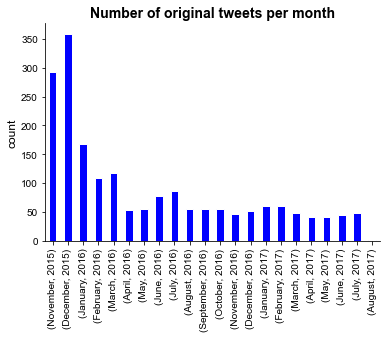

In [197]:
fig, ax = plt.subplots()
sns.set_style("white")
tweets_per_month.plot(kind='bar', color='b')
ax.set_title('Number of original tweets per month', fontsize=14, fontweight="bold")
ax.set_ylabel('count', fontsize=12)
ax.set_xlabel('')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

__November 2015__ and __December 2015__ were the busiest months for WeRateDogs twitter account with the number of original posted tweets, both exceeding 250. From __April 2016__ to __August 2017__, every month had less than 100 tweets total.

Some code has been adapted from:
- https://github.com/MrGeislinger/UdacityDAND_Proj_WrangleAndAnalyzeData
- https://github.com/latinacode/Wrangle-and-Analyze-Data
- https://github.com/NTavou/Wrangle_and_Analyze_Twitter_Data
- https://github.com/gouravaich/wrangle-analyze-weratedogs-twitter